In [1]:
#Импорт библиотек

from pandas import Series
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score

import warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sf-dst-scoring/train.csv
/kaggle/input/sf-dst-scoring/test.csv
/kaggle/input/sf-dst-scoring/sample_submission.csv


In [2]:
RANDOM_SEED = 42
!pip freeze > requirements.txt

path_to_data = '/kaggle/input/sf-dst-scoring/'

# Импорт данных
df_train = pd.read_csv(path_to_data+'train.csv')
df_test = pd.read_csv(path_to_data+'test.csv')

print('df_train: ', df_train.shape)
print('df_test: ', df_test.shape)

df_train:  (73799, 19)
df_test:  (36349, 18)


In [3]:
#Посмотрим на тренеировочные данные
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [4]:
#Посмотрим сколько нулевых значений
df_train.isnull().sum()

client_id             0
app_date              0
education           307
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
default               0
dtype: int64

In [5]:
#Посмотрим на тестовые данные
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

In [6]:
#Посмотрим сколько нулевых значений
df_test.isnull().sum()

client_id             0
app_date              0
education           171
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
dtype: int64

In [7]:
# Объединяем данные

df_train['Train'] = 1 # помечаем трейн
df_test['Train'] = 0 # помечаем тест

df = df_train.append(df_test, sort=False).reset_index(drop=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

В train выборке 73799 клиентов
В test выборке - 36349 клиентов
Всего 110148 клиентов

Всего 19 признаков:
1. client_id - id клиента
2. app_date - дата подачи заявки
3. education - уровень образования
4. sex - пол заемщика
5. age - возраст заемщика
6. car - флаг наличия автомобиля
7. car_type - флаг автомобиля иномарки
8. decline_app_cnt - количество отказанных прошлых заявок
9. good_work - флаг наличия “хорошей” работы
10. score_bki - скоринговый балл по данным из БКИ
11. bki_request_cnt - количество запросов в БКИ
12. region_rating - рейтинг региона
13. home_address - категоризатор домашнего адреса
14. work_address - категоризатор рабочего адреса
15. income - доход заемщика
16. sna - связь заемщика с клиентами банка
17. first_time - давность наличия информации о заемщике
18. foreign_passport - наличие загранпаспорта
19. default - флаг дефолта по кредиту

Признаки деляться на:
1 временной ('app_date'),
6 бинарных ('sex', 'car', 'car_type', 'good_work', 'foreign_passport', 'default'),
6 категориальных ('education', 'region_rating', 'home_address', 'work_address', 'sna', 'first_time')
6 числовых ('client_id', 'age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income')

Пропуски есть только в признаке 'education' - 478 (в train - 307, в test - 171)

# Проведем анализ признаков

client_id. числовой идентификационный признак. Его потом можно удалить

Временной признак app_date

In [9]:
#приведем к формату datetime
from datetime import datetime
df.app_date = pd.to_datetime(df.app_date, format='%d%b%Y')

In [10]:
#Введем новый признак, нумерация дней от минимальной даты
df['days'] = (df.app_date - df.app_date.min()).dt.days.astype('int')

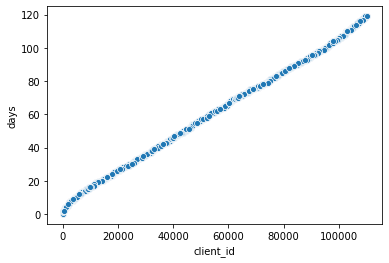

In [11]:
sns.scatterplot(x='client_id',y='days',data=df)

Из графика можно сделать вывод, что в банке ведется нумерация клиентов зависящая от дня обращения в банк

In [12]:
# Введем новый признак, месяц подачи заявки

df['app_date_month'] = df.app_date.dt.month

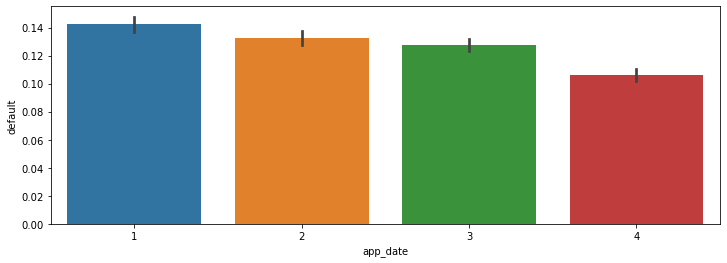

In [13]:
plt.subplots(figsize=(12, 4))
sns.barplot(data=df[df['Train']==1], x=df.loc[df['Train']==1,'app_date'].dt.month, y='default')

Можно сделать вывод, что среднее число дефолтов по тренировочному датасету отрицательно коррелирует с месяцем подачи заявки

In [14]:
# объединим все полученные признаки по категориям
date_cols = ['app_date']
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport'] # default - целевая переменная
cat_cols = ['education', 'region_rating', 'home_address', 'work_address', 'sna', 'first_time', 'app_date_month']
num_cols = ['age','decline_app_cnt','score_bki','bki_request_cnt','income', 'days'] # client_id исключили из списка

# Рассмотрим числовые признаки 

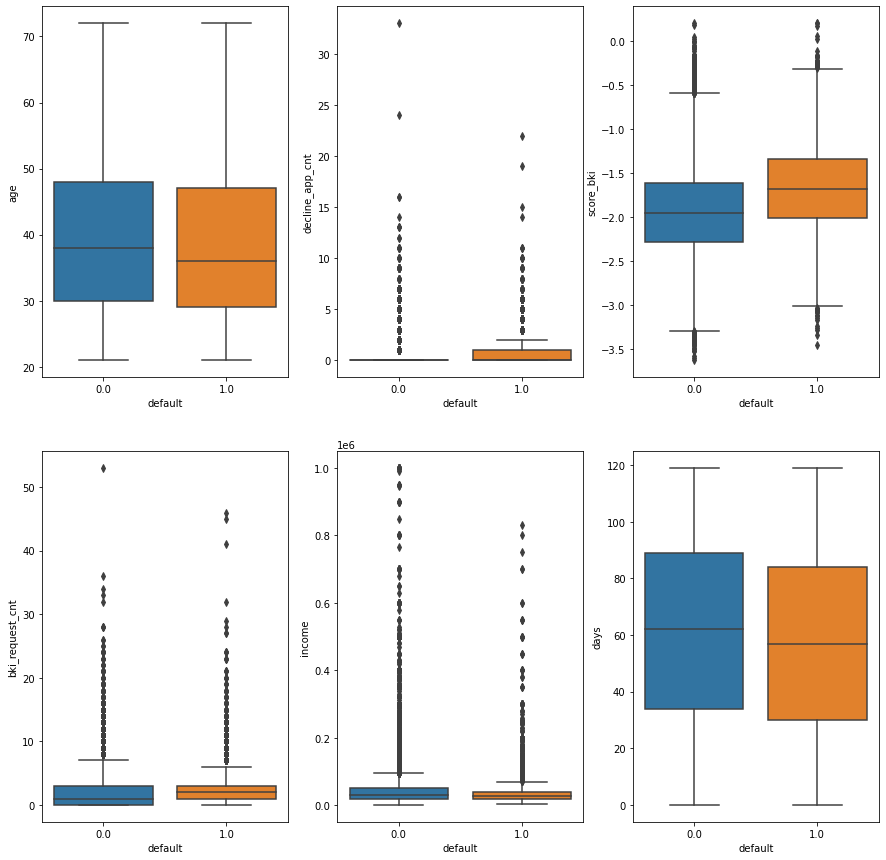

In [15]:
fig, axes = plt.subplots(2, 3, figsize=(15, 15))
axes = axes.flatten()
for i in range(len(num_cols)):
    sns.boxplot(x="default", y=num_cols[i], data=df, ax=axes[i])

Из построенных графиков можно сделать вывод, что выбросы имеют все столбцы, кроме 'age'и 'days

# Рассмотрим категориальные признаки

In [16]:
# Заполним пропуске в колонке education модой
df.education = df.education.fillna(df.education.mode()[0])

In [17]:
#заменим значения SCH,GRD,UGR,PGR и ACD, на 0,1,2,3,4
def fix_education(x):
    x = x.replace('SCH', '0')
    x = x.replace('GRD', '1')
    x = x.replace("UGR", '2')
    x = x.replace("PGR", '3')
    x = x.replace("ACD", '4')

    return x


df['education'] = df['education'].apply(fix_education)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f26a6fd53d0>,
      dtype=object)

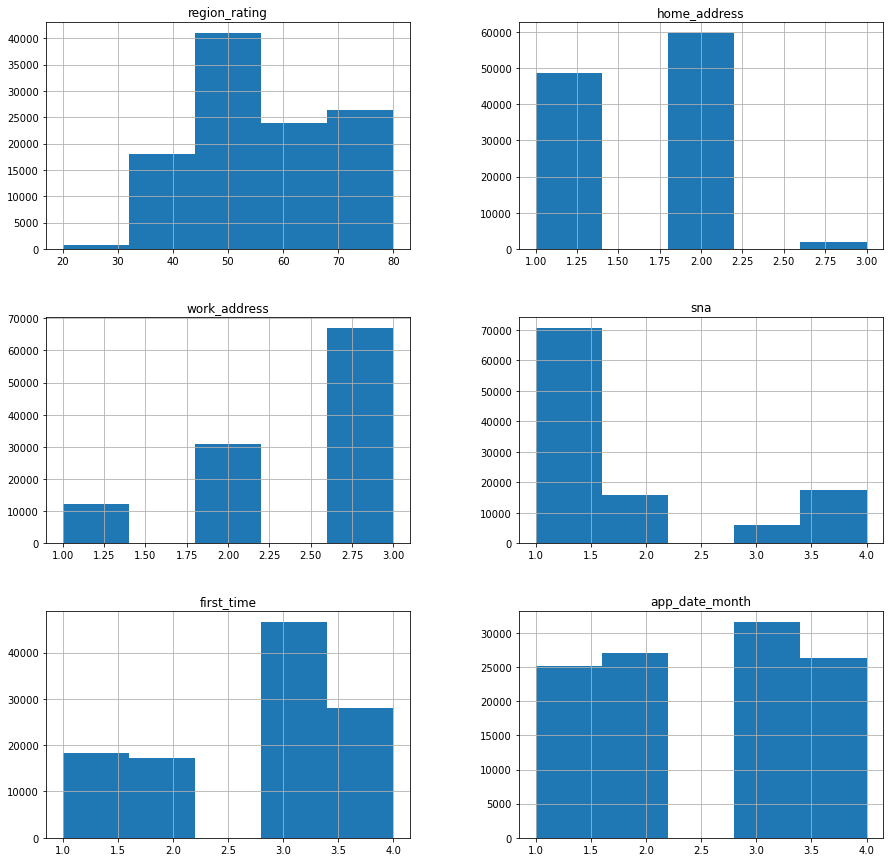

In [18]:
df[cat_cols].hist(figsize = (15,15), bins = 5)

# Рассмотрим бинарные признаки 

In [19]:
# Закодируем их
label_encoder = LabelEncoder()

for column in bin_cols:
    df[column] = label_encoder.fit_transform(df[column])

# Корреляция числовых признаков

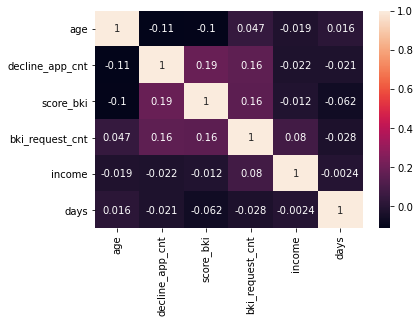

In [20]:
df_num = df[num_cols]
sns.heatmap(df_num.corr(), annot = True)

Как видно из матрицы корреляции сильно скоррелированных признаков нет

# Значимость переменных

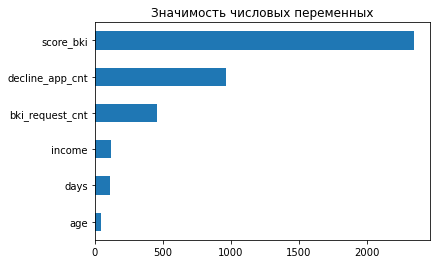

In [21]:
train_df = df[df['Train']==1]
imp_num = pd.Series(f_classif(train_df[num_cols], train_df['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh', title='Значимость числовых переменных')

Из графика видно, что наиболее значимый числовой признак скоринговый балл по данным из БКИ

# Значимость бинарных и категориальных переменных

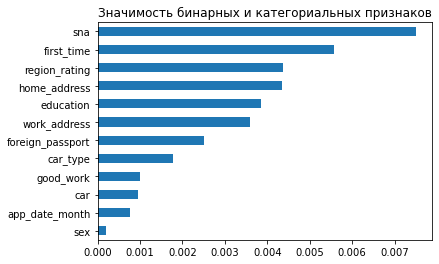

In [22]:
imp_cat = Series(mutual_info_classif(train_df[bin_cols + cat_cols], train_df['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh', title = 'Значимость бинарных и категориальных признаков')

Из графика видно, что наиболее значимый признак связь заемщика с клиентами банка

# Подготовка данных к машинному обучению

In [23]:
df = pd.get_dummies(df, prefix=cat_cols, columns=cat_cols)

In [24]:
# Поскольку в данных выбросы, воспользуемся RobustScaler
scaler = RobustScaler()

df[num_cols] = scaler.fit_transform(df[num_cols].values)

In [25]:
#Удаленим нечисловые критерии
df.drop(['app_date', 'client_id'], axis=1, inplace=True)

# Создание модели

In [26]:
#Разбиваем датасет на тренировочный и тестовый

train_data = df[df['Train'] == 1].drop(['Train'], axis=1)
test_data = df[df['Train'] == 0].drop(['Train'], axis=1)

y = train_data.default.values           
X = train_data.drop(['default'], axis=1).values

In [27]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [28]:
# проверка
test_data.shape, train_data.shape, X.shape, X_train.shape, X_valid.shape

((36349, 42), (73799, 42), (73799, 41), (59039, 41), (14760, 41))

In [29]:
model = LogisticRegression(random_state=RANDOM_SEED)

model.fit(X_train, y_train)

y_pred_prob = model.predict_proba(X_valid)[:,1]
y_pred = model.predict(X_valid)

# Посмотрим метрики

In [30]:
print('Accuracy: %.5f' % accuracy_score(y_valid, y_pred))
print('Precision: %.5f' % precision_score(y_valid, y_pred))
print('Recall: %.5f' % recall_score(y_valid, y_pred))
print('F1: %.5f' % f1_score(y_valid, y_pred))

Accuracy: 0.87419
Precision: 0.36111
Recall: 0.02135
F1: 0.04031


# ROC-AUC

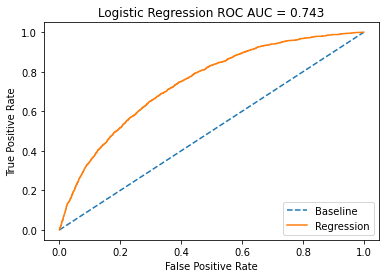

In [31]:
fpr, tpr, threshold = roc_curve(y_valid, y_pred_prob)
roc_auc = roc_auc_score(y_valid, y_pred_prob)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [32]:
TN, FP, FN, TP = confusion_matrix(y_valid, y_pred).ravel()
print(TP, FP) 
print(FN, TN)

39 69
1788 12864


Вывод: модель не угадала дефолтных клиентов. Из 1827 только 39 правильно предсказаны.Попробуем исправить ситуацию, используя настраиваемые гиперпараметры

# Регуляризация

In [33]:
model = LogisticRegression(random_state=RANDOM_SEED)

iter_max = 100

param_grid = [
    {'penalty': ['l1'], 
     'solver': ['liblinear', 'lbfgs'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_max]},
    {'penalty': ['l2'], 
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_max]},
    {'penalty': ['none'], 
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_max]},
]

gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1)
gridsearch.fit(X_train, y_train)
model = gridsearch.best_estimator_
print(model)

LogisticRegression(class_weight='balanced', penalty='none', random_state=42,
                   solver='newton-cg')


In [34]:
# Обучим модель

model.fit(X_train, y_train)

y_pred_prob = model.predict_proba(X_valid)[:,1]
y_pred = model.predict(X_valid)

In [35]:
TN, FP, FN, TP = confusion_matrix(y_valid, y_pred).ravel()
print(TP, FP) 
print(FN, TN)

1243 4254
584 8679


In [36]:
print('Accuracy: %.5f' % accuracy_score(y_valid, y_pred))
print('Precision: %.5f' % precision_score(y_valid, y_pred))
print('Recall: %.5f' % recall_score(y_valid, y_pred))
print('F1: %.5f' % f1_score(y_valid, y_pred))

print('ROC_AUC = ', round(roc_auc_score(y_valid, y_pred_prob), 5))

Accuracy: 0.67222
Precision: 0.22612
Recall: 0.68035
F1: 0.33943
ROC_AUC =  0.7426


Вывод: модель стала лучше угадывать дефолтных клиентов. Из 1827 только 584 правильно предсказаны.

# Submission

In [37]:
train_data = df[df['Train'] == 1].drop(['Train'], axis=1)
test_data = df[df['Train'] == 0].drop(['Train'], axis=1)

In [38]:
X_train=train_data.drop(['default'], axis=1)
y_train = train_data.default.values
X_test = test_data.drop(['default'], axis=1)

In [39]:
predict_submission = model.predict_proba(X_test)[:,1]

submit = pd.DataFrame(df_test.client_id)
submit['default']=predict_submission
submit.to_csv('submission.csv', index=False)